In [1]:
# IMPORTAR LIBRERIAS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve,
    f1_score, accuracy_score, precision_score, recall_score
)
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [2]:
# CARGAR DATOS

ruta_datos = os.path.join(os.getcwd(), "..", "..", "data", "data", "application_train.csv")
datos = pd.read_csv(ruta_datos)

print(f"\n{'='*80}")
print("DATOS CARGADOS")
print(f"{'='*80}")
print(f"Registros: {datos.shape[0]:,}")
print(f"Columnas: {datos.shape[1]}")
print(f"Tasa de fraude (TARGET=1): {datos['TARGET'].mean()*100:.2f}%")
print(f"Casos normales: {(datos['TARGET']==0).sum():,}")
print(f"Casos fraude: {(datos['TARGET']==1).sum():,}")


DATOS CARGADOS
Registros: 307,511
Columnas: 122
Tasa de fraude (TARGET=1): 8.07%
Casos normales: 282,686
Casos fraude: 24,825


In [3]:
# NIVEL 1: REGLAS DE NEGOCIO (SISTEMA EXPERTO)

print("\n" + "="*80)
print("NIVEL 1: APLICANDO REGLAS DE NEGOCIO")
print("="*80)

# Variables derivadas
datos['EDAD'] = -datos['DAYS_BIRTH'] / 365
datos['AÑOS_EMPLEADO'] = -datos['DAYS_EMPLOYED'] / 365
datos['AÑOS_EMPLEADO'] = datos['AÑOS_EMPLEADO'].replace(1000.67, np.nan)

# Ratios financieros
datos['RATIO_CREDITO_INGRESO'] = datos['AMT_CREDIT'] / datos['AMT_INCOME_TOTAL']
datos['RATIO_ANUALIDAD_INGRESO'] = datos['AMT_ANNUITY'] / datos['AMT_INCOME_TOTAL']

# ============================================
# REGLA 1: Zona cara + Ingresos bajos
# ============================================
datos['ZONA_CARA'] = (
    (datos['APARTMENTS_AVG'].fillna(0) > datos['APARTMENTS_AVG'].median()) |
    (datos['LIVINGAREA_AVG'].fillna(0) > datos['LIVINGAREA_AVG'].median()) |
    (datos['ELEVATORS_AVG'].fillna(0) > 0.5)
).astype(int)

datos['INGRESOS_BAJOS'] = (
    datos['AMT_INCOME_TOTAL'] < datos['AMT_INCOME_TOTAL'].quantile(0.25)
).astype(int)

datos['REGLA_1_ZONA_INGRESO'] = (
    (datos['ZONA_CARA'] == 1) & (datos['INGRESOS_BAJOS'] == 1)
).astype(int)

# ============================================
# REGLA 2: Sin empleo + Tiene activos
# ============================================
datos['SIN_EMPLEO'] = (datos['DAYS_EMPLOYED'] > 0).astype(int)
datos['TIENE_AUTO'] = (datos['FLAG_OWN_CAR'] == 'Y').astype(int)
datos['TIENE_CASA'] = (datos['FLAG_OWN_REALTY'] == 'Y').astype(int)

datos['REGLA_2_EMPLEO_ACTIVOS'] = (
    (datos['SIN_EMPLEO'] == 1) & 
    ((datos['TIENE_AUTO'] == 1) | (datos['TIENE_CASA'] == 1))
).astype(int)

# ============================================
# REGLA 3: Educación baja + Ingresos altos
# ============================================
educacion_baja = datos['NAME_EDUCATION_TYPE'].isin(['Lower secondary', 'Incomplete higher'])
ingresos_altos = datos['AMT_INCOME_TOTAL'] > datos['AMT_INCOME_TOTAL'].quantile(0.75)

datos['REGLA_3_EDUCACION_INGRESO'] = (educacion_baja & ingresos_altos).astype(int)

# ============================================
# REGLA 4: Consultas excesivas de crédito
# ============================================
columnas_bureau = [col for col in datos.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
datos['TOTAL_CONSULTAS'] = datos[columnas_bureau].sum(axis=1)
datos['REGLA_4_CONSULTAS_EXCESIVAS'] = (datos['TOTAL_CONSULTAS'] > 5).astype(int)

# ============================================
# REGLA 5: Círculo social riesgoso
# ============================================
datos['DEFAULTS_SOCIALES'] = (
    datos['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0) + 
    datos['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
)
datos['REGLA_5_CIRCULO_RIESGOSO'] = (datos['DEFAULTS_SOCIALES'] > 0).astype(int)

# ============================================
# REGLA 6: Sobreendeudamiento extremo
# ============================================
datos['REGLA_6_SOBREENDEUDAMIENTO'] = (datos['RATIO_CREDITO_INGRESO'] > 8).astype(int)

# ============================================
# SCORE DE REGLAS (0-6)
# ============================================
datos['SCORE_REGLAS_RAW'] = (
    datos['REGLA_1_ZONA_INGRESO'] +
    datos['REGLA_2_EMPLEO_ACTIVOS'] +
    datos['REGLA_3_EDUCACION_INGRESO'] +
    datos['REGLA_4_CONSULTAS_EXCESIVAS'] +
    datos['REGLA_5_CIRCULO_RIESGOSO'] +
    datos['REGLA_6_SOBREENDEUDAMIENTO']
)

# Normalizar a escala 0-1
datos['SCORE_REGLAS'] = datos['SCORE_REGLAS_RAW'] / 6.0

# Estadísticas
print(f"\nRegla 1 (Zona/Ingreso): {datos['REGLA_1_ZONA_INGRESO'].sum():,} casos")
print(f"Regla 2 (Empleo/Activos): {datos['REGLA_2_EMPLEO_ACTIVOS'].sum():,} casos")
print(f"Regla 3 (Educación/Ingreso): {datos['REGLA_3_EDUCACION_INGRESO'].sum():,} casos")
print(f"Regla 4 (Consultas): {datos['REGLA_4_CONSULTAS_EXCESIVAS'].sum():,} casos")
print(f"Regla 5 (Círculo): {datos['REGLA_5_CIRCULO_RIESGOSO'].sum():,} casos")
print(f"Regla 6 (Sobreendeudamiento): {datos['REGLA_6_SOBREENDEUDAMIENTO'].sum():,} casos")

print(f"\nCasos con 2+ reglas activadas: {(datos['SCORE_REGLAS_RAW'] >= 2).sum():,}")
print(f"Casos con 3+ reglas activadas: {(datos['SCORE_REGLAS_RAW'] >= 3).sum():,}")
print(f"Casos con 4+ reglas activadas: {(datos['SCORE_REGLAS_RAW'] >= 4).sum():,}")


NIVEL 1: APLICANDO REGLAS DE NEGOCIO

Regla 1 (Zona/Ingreso): 14,048 casos
Regla 2 (Empleo/Activos): 44,671 casos
Regla 3 (Educación/Ingreso): 3,256 casos
Regla 4 (Consultas): 25,739 casos
Regla 5 (Círculo): 35,166 casos
Regla 6 (Sobreendeudamiento): 24,149 casos

Casos con 2+ reglas activadas: 25,025
Casos con 3+ reglas activadas: 3,194
Casos con 4+ reglas activadas: 207


In [4]:
# NIVEL 2: MACHINE LEARNING (AUTOENCODER)

print("\n" + "="*80)
print("NIVEL 2: ENTRENANDO AUTOENCODER")
print("="*80)

# Seleccionar variables para el autoencoder
variables_ml = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'RATIO_CREDITO_INGRESO', 'RATIO_ANUALIDAD_INGRESO',
    'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'EDAD', 'AÑOS_EMPLEADO', 'DAYS_REGISTRATION',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT', 'REG_CITY_NOT_WORK_CITY',
    'SCORE_REGLAS_RAW'  # Incluir reglas como feature
]

# Preparar datos
X = datos[variables_ml].copy()
y = datos['TARGET'].values

# Imputar nulos
for col in variables_ml:
    if X[col].isnull().sum() > 0:
        if col in ['EXT_SOURCE_2', 'EXT_SOURCE_3']:
            X[col].fillna(X[col].median(), inplace=True)
        else:
            X[col].fillna(0, inplace=True)

# Separar normales para entrenamiento
X_normales = X[datos['TARGET'] == 0].values
X_todos = X.values

# Split
X_train, X_val = train_test_split(X_normales, test_size=0.2, random_state=42)

# Escalar
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_todos_scaled = scaler.transform(X_todos)

print(f"\nDatos de entrenamiento: {X_train_scaled.shape}")
print(f"Datos de validación: {X_val_scaled.shape}")
print(f"Datos totales: {X_todos_scaled.shape}")

# Construir autoencoder
input_dim = X_train_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mae', metrics=['mse'])

print("\nArquitectura del Autoencoder:")
autoencoder.summary()

# Entrenar
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)

print("\nIniciando entrenamiento...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\nEntrenamiento completado en {len(history.history['loss'])} épocas")


NIVEL 2: ENTRENANDO AUTOENCODER

Datos de entrenamiento: (226148, 16)
Datos de validación: (56538, 16)
Datos totales: (307511, 16)

Arquitectura del Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,160 (31.88 KB)

 Trainable params: 7,776 (30.38 KB)

 Non-trainable params: 384 (1.50 KB)


Iniciando entrenamiento...
Epoch 1/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7278 - mse: 153.7468 - val_loss: 0.5354 - val_mse: 3.7843 - learning_rate: 0.0010
Epoch 2/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4391 - mse: 1.3610 - val_loss: 0.2762 - val_mse: 0.2737 - learning_rate: 0.0010
Epoch 3/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4129 - mse: 1.3838 - val_loss: 0.2382 - val_mse: 0.2273 - learning_rate: 0.0010
Epoch 4/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4092 - mse: 1.5049 - val_loss: 0.1998 - val_mse: 0.1575 - learning_rate: 0.0010
Epoch 5/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3996 - mse: 1.5380 - val_loss: 0.2331 - val_mse: 0.1898 - learning_rate: 0.0010
Epoch 6/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3949 - mse: 1.5126 - val_loss: 0.1939 - val_mse: 0.1321 - learning_rate: 0.0010
Epoch 7/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3809 - mse: 1.3923 - val_loss: 0.1862 - val_mse: 

In [5]:
# CALCULAR SCORE DE AUTOENCODER

print("\nCalculando errores de reconstrucción...")
X_reconstructed = autoencoder.predict(X_todos_scaled, verbose=0)
error_reconstruccion = np.mean(np.abs(X_todos_scaled - X_reconstructed), axis=1)

# Normalizar errores a escala 0-1
error_min = error_reconstruccion.min()
error_max = error_reconstruccion.max()
datos['SCORE_AUTOENCODER'] = (error_reconstruccion - error_min) / (error_max - error_min)

print(f"Error min: {error_min:.4f}")
print(f"Error max: {error_max:.4f}")
print(f"Error promedio: {error_reconstruccion.mean():.4f}")


Calculando errores de reconstrucción...
Error min: 0.0085
Error max: 88.7819
Error promedio: 0.1304


In [6]:
# MODELO HÍBRIDO: COMBINAR REGLAS + AUTOENCODER

print("\n" + "="*80)
print("MODELO HÍBRIDO: COMBINANDO REGLAS + ML")
print("="*80)

# Score híbrido ponderado
PESO_REGLAS = 0.40
PESO_AUTOENCODER = 0.60

datos['SCORE_HIBRIDO'] = (
    PESO_REGLAS * datos['SCORE_REGLAS'] + 
    PESO_AUTOENCODER * datos['SCORE_AUTOENCODER']
)

print(f"\nPesos del modelo:")
print(f"  Reglas de Negocio: {PESO_REGLAS*100:.0f}%")
print(f"  Autoencoder ML: {PESO_AUTOENCODER*100:.0f}%")

# Clasificación de riesgo
def clasificar_riesgo(score):
    if score > 0.75:
        return 'MUY ALTO'
    elif score > 0.60:
        return 'ALTO'
    elif score > 0.40:
        return 'MEDIO'
    else:
        return 'BAJO'

datos['NIVEL_RIESGO'] = datos['SCORE_HIBRIDO'].apply(clasificar_riesgo)

# Estadísticas por nivel de riesgo
print("\nDistribución de Riesgo:")
for nivel in ['MUY ALTO', 'ALTO', 'MEDIO', 'BAJO']:
    count = (datos['NIVEL_RIESGO'] == nivel).sum()
    pct = count / len(datos) * 100
    fraudes = datos[datos['NIVEL_RIESGO'] == nivel]['TARGET'].sum()
    tasa_fraude = datos[datos['NIVEL_RIESGO'] == nivel]['TARGET'].mean() * 100 if count > 0 else 0
    print(f"  {nivel:10} : {count:6,} casos ({pct:5.2f}%) - {fraudes:5,} fraudes ({tasa_fraude:5.2f}%)")


MODELO HÍBRIDO: COMBINANDO REGLAS + ML

Pesos del modelo:
  Reglas de Negocio: 40%
  Autoencoder ML: 60%

Distribución de Riesgo:
  MUY ALTO   :      0 casos ( 0.00%) -     0 fraudes ( 0.00%)
  ALTO       :      0 casos ( 0.00%) -     0 fraudes ( 0.00%)
  MEDIO      :      1 casos ( 0.00%) -     1 fraudes (100.00%)
  BAJO       : 307,510 casos (100.00%) - 24,824 fraudes ( 8.07%)


In [7]:
# OPTIMIZAR UMBRAL Y CALCULAR MÉTRICAS

print("\n" + "="*80)
print("OPTIMIZACIÓN DE UMBRAL")
print("="*80)

# Buscar mejor umbral basado en F1-Score
thresholds = np.linspace(0.3, 0.8, 50)
mejor_f1 = 0
mejor_threshold = 0
mejor_metricas = {}

for thresh in thresholds:
    predicciones = (datos['SCORE_HIBRIDO'] > thresh).astype(int)
    f1 = f1_score(datos['TARGET'], predicciones, zero_division=0)
    
    if f1 > mejor_f1:
        mejor_f1 = f1
        mejor_threshold = thresh
        mejor_metricas = {
            'accuracy': accuracy_score(datos['TARGET'], predicciones),
            'precision': precision_score(datos['TARGET'], predicciones, zero_division=0),
            'recall': recall_score(datos['TARGET'], predicciones, zero_division=0),
            'f1_score': f1
        }

# Aplicar mejor umbral
datos['PREDICCION_FRAUDE'] = (datos['SCORE_HIBRIDO'] > mejor_threshold).astype(int)

# ROC-AUC
roc_auc = roc_auc_score(datos['TARGET'], datos['SCORE_HIBRIDO'])

print(f"\nMejor umbral encontrado: {mejor_threshold:.4f}")
print(f"\nMÉTRICAS DEL MODELO HÍBRIDO:")
print(f"  Accuracy:  {mejor_metricas['accuracy']:.4f}")
print(f"  Precision: {mejor_metricas['precision']:.4f}")
print(f"  Recall:    {mejor_metricas['recall']:.4f}")
print(f"  F1-Score:  {mejor_metricas['f1_score']:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

print(f"\nReporte de Clasificación:")
print(classification_report(datos['TARGET'], datos['PREDICCION_FRAUDE'], 
                           target_names=['Normal', 'Fraude'], zero_division=0))


OPTIMIZACIÓN DE UMBRAL

Mejor umbral encontrado: 0.3000

MÉTRICAS DEL MODELO HÍBRIDO:
  Accuracy:  0.9193
  Precision: 0.7500
  Recall:    0.0001
  F1-Score:  0.0002
  ROC-AUC:   0.5160

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96    282686
      Fraude       0.75      0.00      0.00     24825

    accuracy                           0.92    307511
   macro avg       0.83      0.50      0.48    307511
weighted avg       0.91      0.92      0.88    307511



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


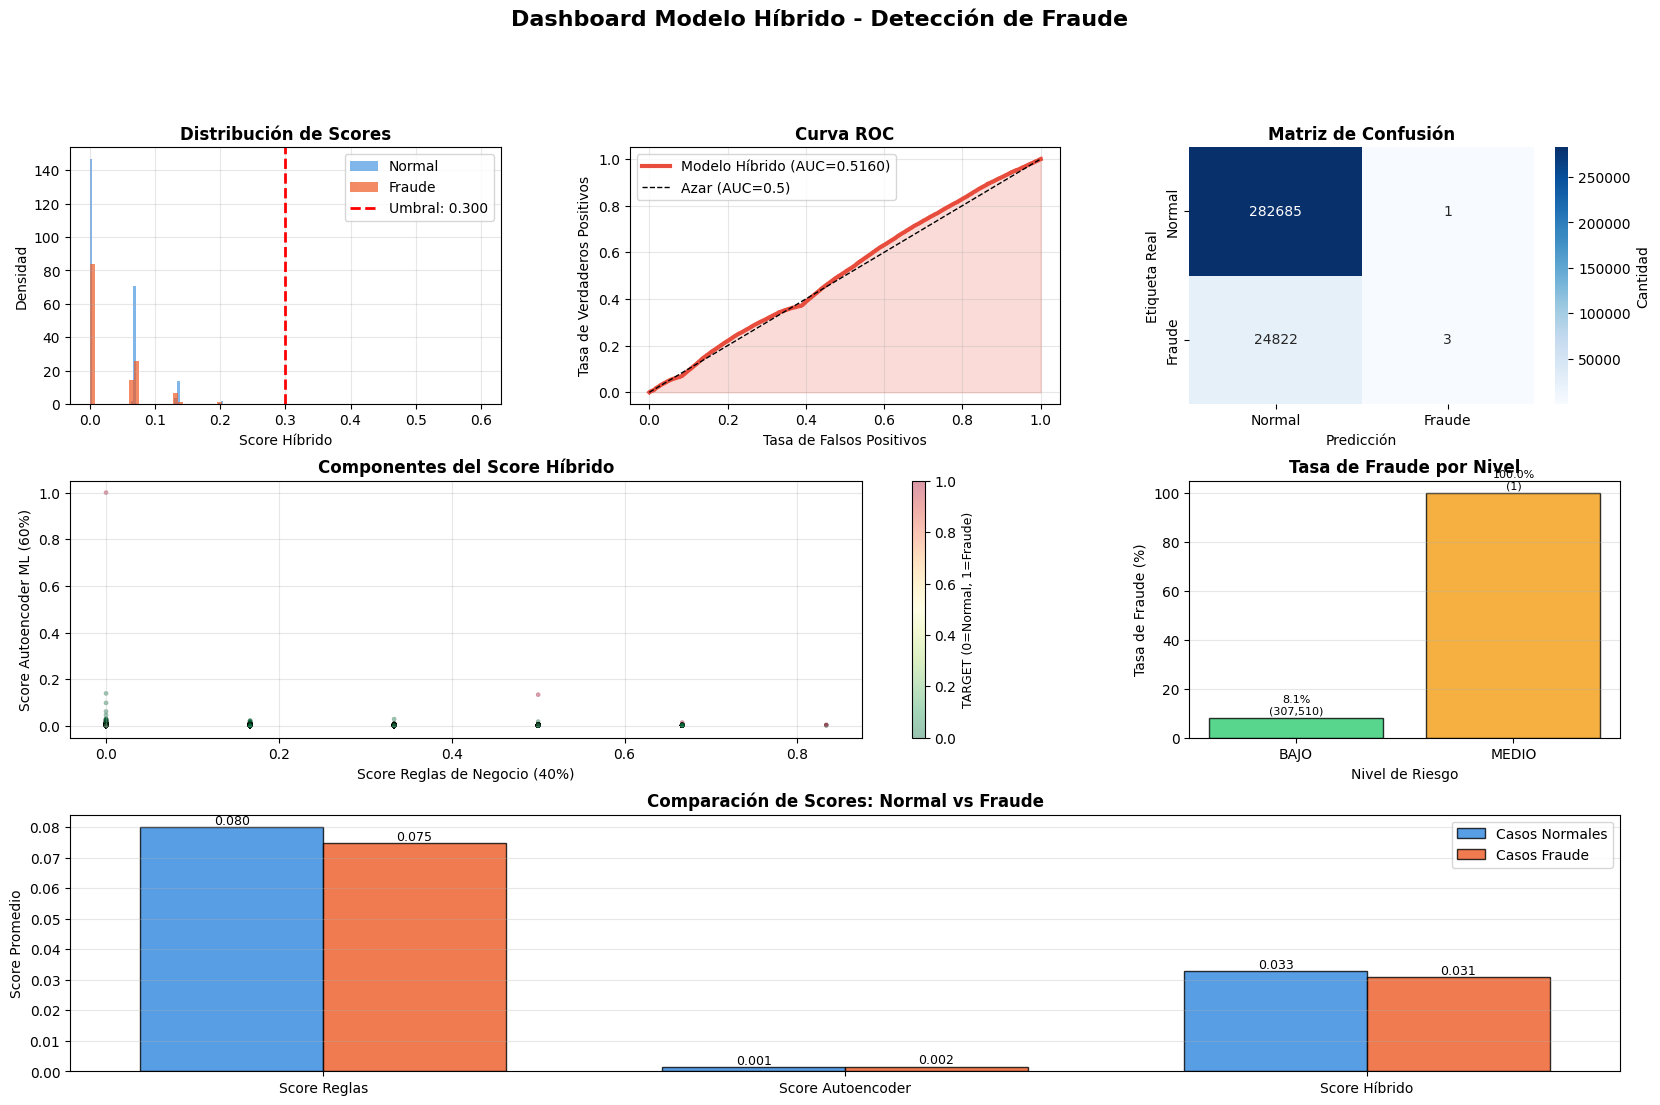

In [8]:
# VISUALIZACIONES MEJORADAS

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribución de scores híbrido
ax1 = fig.add_subplot(gs[0, 0])
normales = datos[datos['TARGET'] == 0]['SCORE_HIBRIDO']
fraudes = datos[datos['TARGET'] == 1]['SCORE_HIBRIDO']

ax1.hist(normales, bins=80, alpha=0.6, label='Normal', color='#2E86DE', density=True)
ax1.hist(fraudes, bins=80, alpha=0.7, label='Fraude', color='#EE5A24', density=True)
ax1.axvline(mejor_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Umbral: {mejor_threshold:.3f}')
ax1.set_xlabel('Score Híbrido', fontsize=10)
ax1.set_ylabel('Densidad', fontsize=10)
ax1.set_title('Distribución de Scores', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Curva ROC
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(datos['TARGET'], datos['SCORE_HIBRIDO'])
ax2.plot(fpr, tpr, linewidth=3, label=f'Modelo Híbrido (AUC={roc_auc:.4f})', color='#e74c3c')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Azar (AUC=0.5)')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#e74c3c')
ax2.set_xlabel('Tasa de Falsos Positivos', fontsize=10)
ax2.set_ylabel('Tasa de Verdaderos Positivos', fontsize=10)
ax2.set_title('Curva ROC', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Matriz de confusión
ax3 = fig.add_subplot(gs[0, 2])
cm = confusion_matrix(datos['TARGET'], datos['PREDICCION_FRAUDE'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
           xticklabels=['Normal', 'Fraude'],
           yticklabels=['Normal', 'Fraude'],
           cbar_kws={'label': 'Cantidad'})
ax3.set_ylabel('Etiqueta Real', fontsize=10)
ax3.set_xlabel('Predicción', fontsize=10)
ax3.set_title('Matriz de Confusión', fontsize=12, fontweight='bold')

# 4. Componentes del Score (Scatter mejorado)
ax4 = fig.add_subplot(gs[1, :2])
scatter = ax4.scatter(datos['SCORE_REGLAS'], datos['SCORE_AUTOENCODER'],
                     c=datos['TARGET'], cmap='RdYlGn_r', alpha=0.4, s=10, 
                     edgecolors='black', linewidth=0.1)
ax4.set_xlabel('Score Reglas de Negocio (40%)', fontsize=10)
ax4.set_ylabel('Score Autoencoder ML (60%)', fontsize=10)
ax4.set_title('Componentes del Score Híbrido', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('TARGET (0=Normal, 1=Fraude)', fontsize=9)

# 5. Tasa de fraude por nivel de riesgo
ax5 = fig.add_subplot(gs[1, 2])
niveles = ['BAJO', 'MEDIO', 'ALTO', 'MUY ALTO']
tasas_fraude = []
conteos = []
for nivel in niveles:
    mask = datos['NIVEL_RIESGO'] == nivel
    tasa = datos[mask]['TARGET'].mean() * 100
    count = mask.sum()
    tasas_fraude.append(tasa)
    conteos.append(count)

colores = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']
bars = ax5.bar(niveles, tasas_fraude, color=colores, alpha=0.8, edgecolor='black')
ax5.set_xlabel('Nivel de Riesgo', fontsize=10)
ax5.set_ylabel('Tasa de Fraude (%)', fontsize=10)
ax5.set_title('Tasa de Fraude por Nivel', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

for i, (bar, tasa, count) in enumerate(zip(bars, tasas_fraude, conteos)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{tasa:.1f}%\n({count:,})',
            ha='center', va='bottom', fontsize=8)

# 6. Comparación de scores promedio
ax6 = fig.add_subplot(gs[2, :])
categorias = ['Score Reglas', 'Score Autoencoder', 'Score Híbrido']
x = np.arange(len(categorias))
width = 0.35

scores_normal = [
    datos[datos['TARGET'] == 0]['SCORE_REGLAS'].mean(),
    datos[datos['TARGET'] == 0]['SCORE_AUTOENCODER'].mean(),
    datos[datos['TARGET'] == 0]['SCORE_HIBRIDO'].mean()
]

scores_fraude = [
    datos[datos['TARGET'] == 1]['SCORE_REGLAS'].mean(),
    datos[datos['TARGET'] == 1]['SCORE_AUTOENCODER'].mean(),
    datos[datos['TARGET'] == 1]['SCORE_HIBRIDO'].mean()
]

bars1 = ax6.bar(x - width/2, scores_normal, width, label='Casos Normales', 
               color='#2E86DE', alpha=0.8, edgecolor='black')
bars2 = ax6.bar(x + width/2, scores_fraude, width, label='Casos Fraude', 
               color='#EE5A24', alpha=0.8, edgecolor='black')

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax6.set_ylabel('Score Promedio', fontsize=10)
ax6.set_title('Comparación de Scores: Normal vs Fraude', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(categorias, fontsize=10)
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('Dashboard Modelo Híbrido - Detección de Fraude', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

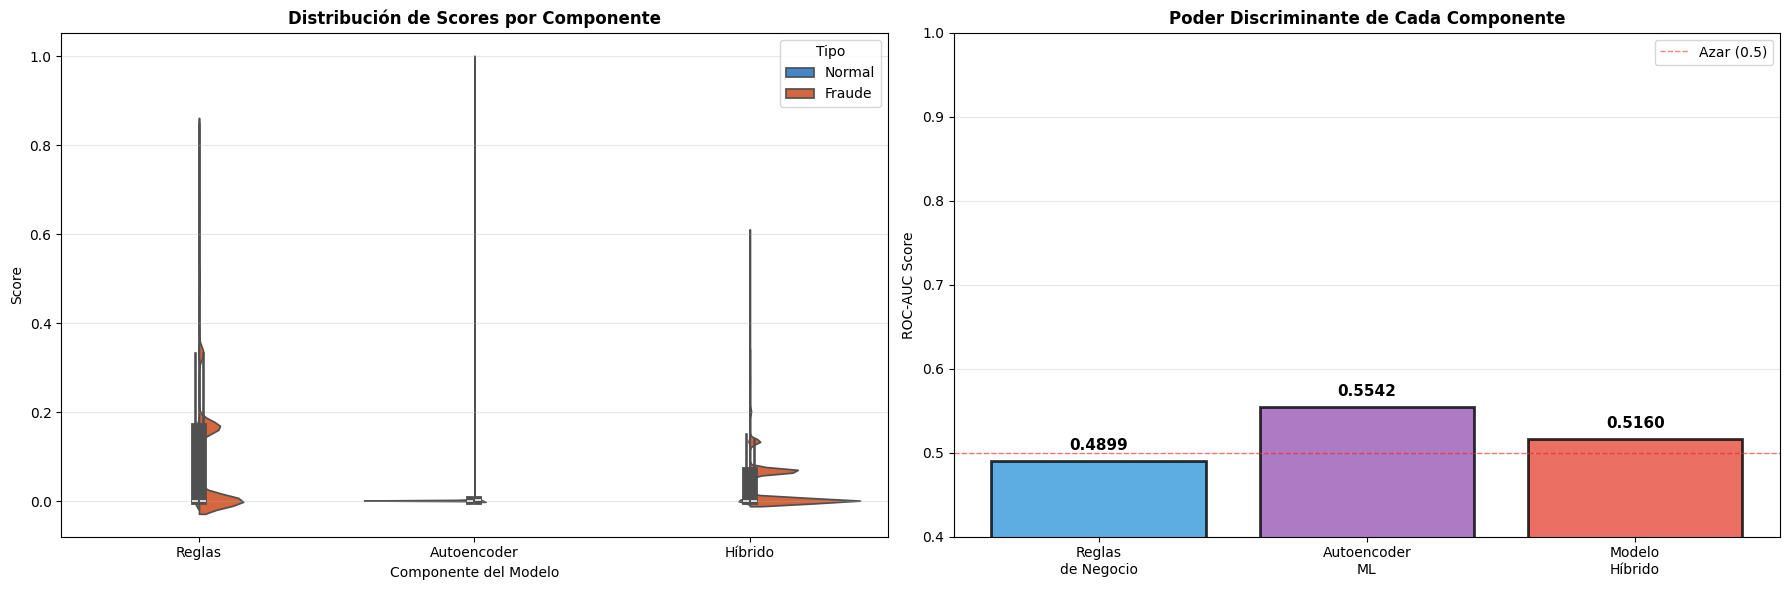

In [9]:
# ANÁLISIS DE COMPONENTES DEL SCORE

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Violin plot: distribución de scores por TARGET
data_violin = pd.DataFrame({
    'Reglas': np.concatenate([datos[datos['TARGET']==0]['SCORE_REGLAS'].values,
                              datos[datos['TARGET']==1]['SCORE_REGLAS'].values]),
    'Autoencoder': np.concatenate([datos[datos['TARGET']==0]['SCORE_AUTOENCODER'].values,
                                   datos[datos['TARGET']==1]['SCORE_AUTOENCODER'].values]),
    'Híbrido': np.concatenate([datos[datos['TARGET']==0]['SCORE_HIBRIDO'].values,
                               datos[datos['TARGET']==1]['SCORE_HIBRIDO'].values]),
    'Tipo': ['Normal']*len(datos[datos['TARGET']==0]) + ['Fraude']*len(datos[datos['TARGET']==1])
})

data_melted = data_violin.melt(id_vars='Tipo', var_name='Componente', value_name='Score')

sns.violinplot(data=data_melted, x='Componente', y='Score', hue='Tipo', 
              split=True, ax=axes[0], palette={'Normal': '#2E86DE', 'Fraude': '#EE5A24'})
axes[0].set_title('Distribución de Scores por Componente', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=10)
axes[0].set_xlabel('Componente del Modelo', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Poder discriminante de cada componente
componentes = ['Reglas\nde Negocio', 'Autoencoder\nML', 'Modelo\nHíbrido']
aucs = []

for col in ['SCORE_REGLAS', 'SCORE_AUTOENCODER', 'SCORE_HIBRIDO']:
    auc = roc_auc_score(datos['TARGET'], datos[col])
    aucs.append(auc)

colores_auc = ['#3498db', '#9b59b6', '#e74c3c']
bars = axes[1].bar(componentes, aucs, color=colores_auc, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Azar (0.5)')
axes[1].set_ylabel('ROC-AUC Score', fontsize=10)
axes[1].set_title('Poder Discriminante de Cada Componente', fontsize=12, fontweight='bold')
axes[1].set_ylim([0.4, 1.0])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

for i, (bar, auc) in enumerate(zip(bars, aucs)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{auc:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
# TOP 10 CASOS MÁS RIESGOSOS

top_10 = datos.nlargest(10, 'SCORE_HIBRIDO').copy()

print("\n" + "="*100)
print("TOP 10 CASOS DE MAYOR RIESGO (MODELO HÍBRIDO)")
print("="*100)

for idx, (i, fila) in enumerate(top_10.iterrows(), 1):
    print(f"\nCASO #{idx} - ID: {int(fila['SK_ID_CURR'])}")
    print(f"Score Híbrido: {fila['SCORE_HIBRIDO']:.4f} | Nivel: {fila['NIVEL_RIESGO']}")
    print(f"TARGET Real: {'FRAUDE ⚠️' if fila['TARGET']==1 else 'NORMAL ✓'}")
    
    print(f"\nDesglose del Score:")
    print(f"  Score Reglas (40%):      {fila['SCORE_REGLAS']:.4f}")
    print(f"  Score Autoencoder (60%): {fila['SCORE_AUTOENCODER']:.4f}")
    
    print(f"\nPerfil Financiero:")
    print(f"  Ingreso: ${fila['AMT_INCOME_TOTAL']:,.0f}")
    print(f"  Crédito: ${fila['AMT_CREDIT']:,.0f}")
    print(f"  Ratio Crédito/Ingreso: {fila['RATIO_CREDITO_INGRESO']:.2f}x")
    
    print(f"\nReglas Activadas ({int(fila['SCORE_REGLAS_RAW'])}/6):")
    if fila['REGLA_1_ZONA_INGRESO'] == 1:
        print("  ⚠️ Zona cara + ingresos bajos")
    if fila['REGLA_2_EMPLEO_ACTIVOS'] == 1:
        print("  ⚠️ Sin empleo + tiene activos")
    if fila['REGLA_3_EDUCACION_INGRESO'] == 1:
        print("  ⚠️ Educación baja + ingresos altos")
    if fila['REGLA_4_CONSULTAS_EXCESIVAS'] == 1:
        print(f"  ⚠️ Consultas excesivas ({int(fila['TOTAL_CONSULTAS'])})")
    if fila['REGLA_5_CIRCULO_RIESGOSO'] == 1:
        print(f"  ⚠️ Círculo social riesgoso ({int(fila['DEFAULTS_SOCIALES'])} defaults)")
    if fila['REGLA_6_SOBREENDEUDAMIENTO'] == 1:
        print("  ⚠️ Sobreendeudamiento extremo")
    
    print("-" * 100)

print(f"\nRESUMEN TOP 10:")
print(f"Fraudes reales: {int(top_10['TARGET'].sum())}/10")
print(f"Score promedio: {top_10['SCORE_HIBRIDO'].mean():.4f}")
print(f"Reglas promedio activadas: {top_10['SCORE_REGLAS_RAW'].mean():.1f}/6")


TOP 10 CASOS DE MAYOR RIESGO (MODELO HÍBRIDO)

CASO #1 - ID: 114967
Score Híbrido: 0.6000 | Nivel: MEDIO
TARGET Real: FRAUDE ⚠️

Desglose del Score:
  Score Reglas (40%):      0.0000
  Score Autoencoder (60%): 1.0000

Perfil Financiero:
  Ingreso: $117,000,000
  Crédito: $562,491
  Ratio Crédito/Ingreso: 0.00x

Reglas Activadas (0/6):
----------------------------------------------------------------------------------------------------

CASO #2 - ID: 456088
Score Híbrido: 0.3364 | Nivel: BAJO
TARGET Real: FRAUDE ⚠️

Desglose del Score:
  Score Reglas (40%):      0.8333
  Score Autoencoder (60%): 0.0051

Perfil Financiero:
  Ingreso: $29,250
  Crédito: $663,093
  Ratio Crédito/Ingreso: 22.67x

Reglas Activadas (5/6):
  ⚠️ Zona cara + ingresos bajos
  ⚠️ Sin empleo + tiene activos
  ⚠️ Consultas excesivas (6)
  ⚠️ Círculo social riesgoso (2 defaults)
  ⚠️ Sobreendeudamiento extremo
----------------------------------------------------------------------------------------------------

CASO #

In [11]:
# EXPORTAR MÉTRICAS PARA COMPARACIÓN

metricas_finales = {
    'Modelo': 'Modelo Híbrido (Reglas + ML)',
    'Accuracy': mejor_metricas['accuracy'],
    'Precision': mejor_metricas['precision'],
    'Recall': mejor_metricas['recall'],
    'F1-Score': mejor_metricas['f1_score'],
    'ROC-AUC': roc_auc
}

df_metricas = pd.DataFrame([metricas_finales])

print("\n" + "="*80)
print("MÉTRICAS FINALES - MODELO HÍBRIDO")
print("="*80)
print(df_metricas.to_string(index=False))
print("\n" + "="*80)

print("\nRESUMEN EJECUTIVO:")
print(f"Enfoque: Híbrido (40% Reglas de Negocio + 60% Autoencoder ML)")
print(f"Casos analizados: {len(datos):,}")
print(f"Fraudes reales: {datos['TARGET'].sum():,} ({datos['TARGET'].mean()*100:.2f}%)")
print(f"\nRendimiento:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  F1-Score: {mejor_metricas['f1_score']:.4f}")
print(f"  Precisión: {mejor_metricas['precision']:.4f}")
print(f"  Recall: {mejor_metricas['recall']:.4f}")
df_metricas


MÉTRICAS FINALES - MODELO HÍBRIDO
                      Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Modelo Híbrido (Reglas + ML)  0.919278       0.75 0.000121  0.000242 0.516006


RESUMEN EJECUTIVO:
Enfoque: Híbrido (40% Reglas de Negocio + 60% Autoencoder ML)
Casos analizados: 307,511
Fraudes reales: 24,825 (8.07%)

Rendimiento:
  ROC-AUC: 0.5160
  F1-Score: 0.0002
  Precisión: 0.7500
  Recall: 0.0001


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Modelo Híbrido (Reglas + ML),0.919278,0.75,0.000121,0.000242,0.516006
